# Video Processing for BT Lab
Functions to check if run is good
<br>
<br>
![UofC logo](./pictures/uofc_logo-black.jpg)

In [1]:
#import libraries
import os
import re
import json
from pathlib import Path
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import cv2
from PIL import Image
from typing import List, Optional, Tuple

# plot
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
# faster r-cnn
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [3]:
# import sk libraries
from sklearn.model_selection import train_test_split

In [4]:
# make sure to update path
user_drive = input("Enter user drive: ").upper()
video_path = f"{user_drive}:/DI_centre_structured"
input(f"Is this the right directory - {video_path}?")

''

In [5]:
VIDEO_CHARACTERISTICS = {
    "With Blankets" : "WB",
    "B" : "WB",
    "Without Blankets" : "WOB",
    "WOB": "WOB",
    "3 Meters" : "3m",
    "2 Meters" : "2m",
    "Hold Breath" : "HB",
    "Hold Breathe" : "HB",
    "H" : "HB",
    "Relaxed" : "rel",
    "R": "rel",
}

# for testing
FRAME_LIMIT = 100

# labels
RELAXED_LABEL = 0
HOLD_BREATH_LABEL = 1

In [6]:
# local dirs
repo_dir = os.getcwd()
json_dir = repo_dir + "/records/JSON"
log_dir = repo_dir + "/records/logs"

In [7]:
def get_video_frame_paths(local_path: str, level: str) -> List[str]:
    """
    Constructs and returns paths related to video frames.

    Parameters:
    local_path (str): The local file path of the video.
    level (str): The detail level for the frames.

    Returns:
    List[str]: A list containing the folder path for frames and the video folder path.
    """
    video_folder, video_filename_with_ext = os.path.split(local_path)
    video_filename = os.path.splitext(video_filename_with_ext)[0]
    folder_path = os.path.join(video_folder, f"frames_{video_filename}_{level}")
    return [folder_path, video_folder]

In [8]:
def resample_frames(old_fps: int, new_fps: int, start: int) -> List[int]:
    """
    Resamples the number of frames from an old frame rate to a new frame rate. 
    This function can handle both upsampling and downsampling.

    Parameters:
    old_fps (int): The original frames per second.
    new_fps (int): The new frames per second to resample to.
    start (int): The starting frame index.

    Returns:
    List[int]: A list of frame indices after resampling.

    Raises:
    ValueError: If old_fps or new_fps are non-positive integers.
    """
    if old_fps <= 0 or new_fps <= 0:
        raise ValueError("old_fps and new_fps must be positive integers.")

    original_frame_indices = np.arange(start, old_fps, dtype=int)
    interpolated_frame_positions = np.linspace(start, old_fps - 1, new_fps)
    nearest_frame_indices = np.round(interpolated_frame_positions).astype(int)
    resampled_frame_indices = np.take(original_frame_indices, nearest_frame_indices, mode='wrap')

    return resampled_frame_indices.tolist()

In [9]:
def create_patient_video_id(patient_data: dict, video_count: int) -> str:
    """
    Creates a unique ID for a patient video scenario.

    Parameters:
    patient_data (dict): Dictionary containing patient information.
    video_count (int): The count of videos for the patient.

    Returns:
    str: A unique ID string for the video.
    """
    alias = patient_data.get("alias", "Unknown")
    blanket = VIDEO_CHARACTERISTICS.get(patient_data.get("blanket", ""), "?")
    distance = VIDEO_CHARACTERISTICS.get(patient_data.get("distance", "").title(), "?")
    breathing = VIDEO_CHARACTERISTICS.get(patient_data.get("breathing", ""), "?")

    return f"{alias}_{video_count}-{distance}-{blanket}-{breathing}"

In [10]:
def set_folder(save_folder: str) -> None:
    """
    Ensures the specified folder exists and is empty.
    If the folder doesn't exist, it is created. If it exists, its contents are removed.

    Args:
    save_folder (str): The path to the folder.
    """
    folder_path = Path(save_folder)
    if not folder_path.is_dir():
        folder_path.mkdir(parents=True, exist_ok=True)
    else:
        try:
            for file_name in folder_path.iterdir():
                if file_name.is_file():
                    file_name.unlink()
        except OSError as e:
            print(f"Error: {e}")

In [11]:
def folder_exists(folder_path: str) -> bool:
    """Checks if the specified folder exists."""
    return os.path.exists(folder_path)

In [12]:
def extract_video_metadata(video_path: str) -> Tuple[int, int]:
    """Extracts metadata from the video file."""
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise RuntimeError(f"Failed to open video file {video_path}")

    try:
        vid_fps = int(video.get(cv2.CAP_PROP_FPS))
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    finally:
        video.release()

    return vid_fps, total_frames

def calculate_expected_frame_count(vid_fps: int, total_frames: int, new_fps: int) -> int:
    """Calculates the expected number of frames."""
    vid_duration = total_frames // vid_fps
    return new_fps * vid_duration

def count_frames_in_folder(folder_path: str) -> int:
    """Counts the number of frames (files) in the given folder."""
    return len(os.listdir(folder_path))

def run_folder_check(video_path: str, save_folder: str, new_fps: int) -> Optional[str]:
    """
    Checks if the specified folder has the correct number of frames extracted from a video.
    Returns the folder path if the frame count does not match.
    """
    try:
        vid_fps, total_frames = extract_video_metadata(video_path)
        expected_frame_count = calculate_expected_frame_count(vid_fps, total_frames, new_fps)
        actual_frame_count = count_frames_in_folder(save_folder)

        if actual_frame_count != expected_frame_count:
            print(f"{save_folder} - Incorrect frame count. Found {actual_frame_count}, expected {expected_frame_count}.\n")
            return save_folder
    except RuntimeError as e:
        print(str(e))
        return None

    return None


In [13]:
def check_and_report_folder_existence(folder_path: str) -> bool:
    """
    Check if a folder exists and report if it doesn't.

    Args:
    folder_path (str): The path to the folder to check.

    Returns:
    bool: True if the folder exists, False otherwise. Prints a message if the folder doesn't exist.
    """
    if not folder_exists(folder_path):
        print(f"{folder_path} does not exist.")
        return False
    return True

def process_patient_folder(patient_info: dict, new_fps: int, level: str) -> Tuple[Optional[str], str]:
    """
    Process a patient's folder to determine if it needs rerunning and return its frame path.

    Args:
    patient_info (dict): Information about the patient.
    new_fps (int): The new frames per second value to check against.
    level (str): The processing level.

    Returns:
    Tuple[Optional[str], str]: A tuple containing the folder to rerun (if any), and the frame folder path.
    """
    video_path = patient_info["local path"]
    frames_folder, _ = get_video_frame_paths(video_path, level)

    if not check_and_report_folder_existence(frames_folder):
        return None, frames_folder

    rerun_folder = run_folder_check(video_path, frames_folder, new_fps)

    return rerun_folder, frames_folder

def validate_run(all_patients: dict, level: str, new_fps: int) -> Tuple[List[str], List[str]]:
    """
    Validate the run for all patients and determine if any folders need rerunning.

    Args:
    all_patients (dict): A dictionary containing information about all patients.
    level (str): The processing level.
    new_fps (int): The new frames per second value to check against.

    Returns:
    Tuple[List[str], List[str]]: A tuple containing two lists: folders to rerun and frame folders.
    """
    rerun_folders = []
    frames_folders = []

    for patient_id, patient_info in all_patients.items():
        try:
            rerun_folder, frames_folder = process_patient_folder(patient_info, new_fps, level)
            frames_folders.append(frames_folder)
            if rerun_folder:
                rerun_folders.append(rerun_folder)
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")

    return rerun_folders, frames_folders

In [14]:
# export to json

def export_to_json(filename: str, all_patient_info: dict) -> None:
    patient_json = json.dumps(all_patient_info, indent=2)

    with open(filename, "w") as json_data:
        json_data.write(patient_json)

In [15]:
def load_json(json_dir: str, filename: str) -> dict:
    # Remove leading slash if present in filename
    if filename.startswith("/"):
        filename = filename[1:]

    full_path = os.path.join(json_dir, filename)

    try:
        with open(full_path, "r") as json_data:
            return json.load(json_data)
    except FileNotFoundError:
        print(f"Error: The file {full_path} does not exist.")
        return {}
    except json.JSONDecodeError:
        print(f"Error: The file {full_path} is not a valid JSON.")
        return {} 

# Run tests

In [16]:
""" local vars"""

rgb_fps = {
    "lower_bound": 10,
    "upper_bound": 20
}

thermal_fps = {
    "lower_bound": 5,
    "upper_bound": 10
}

In [17]:
""" load JSON files """

metadata_rgb = load_json(json_dir, "/rgb_complete.json")
metadata_thermal = load_json(json_dir, "/thermal_complete.json")

In [18]:
""" check videos (rgb) """
all_rgb_folders = []
all_rgb_rerun_folders = []

for level, new_fps in rgb_fps.items():
    print(f"\nAdjusting FPS to {new_fps}\n" + "="*50)
    rerun_folders, visited_folders = validate_run(metadata_rgb, level, new_fps)
    all_rgb_rerun_folders.append(rerun_folders)
    all_rgb_folders.append(visited_folders)


Adjusting FPS to 10

Adjusting FPS to 20


In [19]:
""" check videos (thermal) """
# all_thermal_folders = []
# all_thermal_rerun_folders = []

# for level, new_fps in thermal_fps.items():
#     print(f"\nAdjusting FPS to {new_fps}\n" + "="*50)
#     rerun_folders, visited_folders = check_if_empty_folders(metadata_thermal, level, new_fps, user_drive)
#     all_thermal_folders.append(visited_folders)
#     all_thermal_rerun_folders.append(rerun_folders)

' check videos (thermal) '

# Crop Image

In [20]:
def detect_objects(img, model, threshold=0.5):
    # Convert the image to RGB and then to a tensor
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img_rgb)

    # Put the model in evaluation mode and apply to the image
    model.eval()
    with torch.no_grad():
        prediction = model([img_tensor])

    # Collect bounding boxes
    bboxes = []
    for element in range(len(prediction[0]['boxes'])):
        if prediction[0]['scores'][element] > threshold:
            box = prediction[0]['boxes'][element].cpu().numpy()
            label = prediction[0]['labels'][element].cpu().numpy()
            
            if label == 1:  # COCO Dataset label for 'person'
                bboxes.append(box)

    return bboxes

In [21]:
def extract_folder_details(path):
    """
    Extracts the folder name and its direct parent folder path from a given file path.
    
    Parameters:
    path (str): The file path from which the folder name and parent path are to be extracted.
    
    Returns:
    tuple: A tuple containing two elements:
           - The name of the folder (str)
           - The path to its direct parent folder (str)
    """
    normalized_path = os.path.normpath(path)
    folder_name = os.path.basename(normalized_path)
    parent_path = os.path.dirname(normalized_path)

    return folder_name, parent_path

In [22]:
def crop_and_save_image(input_image_path, coordinates, output_image_path):
    """
    Crops an image based on the given coordinates and saves the cropped image to a specified path.

    Parameters:
    input_image_path (str): The path to the input image to be cropped.
    coordinates (list): A list of coordinates in the format [x_min, y_min, x_max, y_max].
    output_image_path (str): The path where the cropped image will be saved.

    Returns:
    None: The function saves the cropped image to the specified path and does not return anything.
    """
    with Image.open(input_image_path) as img:
        cropped_image = img.crop(coordinates)
        cropped_image.save(output_image_path)

In [23]:
def get_first_image_bounding_boxes(folders, model):
    """
    Extracts bounding box data for the first image in each provided folder.
    Uses a user-defined function 'detect_objects' for object detection.

    Args:
        folders (list of str): Paths to folders containing images.
        model (object): The object detection model.

    Returns:
        dict: A mapping from folder paths to the first image's bounding box data.
    
    Raises:
        IOError: If an image cannot be read from a folder.
        Exception: For other errors during processing.
    """
    bounding_boxes_by_folder = {}

    for folder in folders:
        first_image_path = os.path.join(folder, os.listdir(folder)[0])
        image = cv2.imread(first_image_path)

        if image is not None:
            try:
                detection_result = detect_objects(image, model)
                # Assuming detect_objects returns a list or None
                bounding_box = detection_result[0].tolist() if detection_result else None
                bounding_boxes_by_folder[folder] = bounding_box
            except Exception as error:
                print(f"Error during bounding box detection in {folder}: {error}")
        else:
            raise IOError(f"Could not read the image at {first_image_path}")

    return bounding_boxes_by_folder


In [24]:
def crop_all_images_in_folders(folders, crop_coordinates):
    """
    Crops all images in each provided folder based on the given crop coordinates.

    Args:
        folders (list of str): A list of folder paths containing images.
        crop_coordinates (list): A list of coordinates [x_min, y_min, x_max, y_max] for cropping.

    Note:
        set_folder, extract_folder_details, and crop_and_save_image should be defined in the scope where this function is called.
    """

    all_paths = []

    for folder in folders:
        folder_name, parent_path = extract_folder_details(folder)
        cropped_path = os.path.join(parent_path, f"{folder_name}-cropped")
        all_paths.append(cropped_path)
        all_images = os.listdir(folder)

        set_folder(cropped_path)

        for image_name in all_images:
            input_image_path = os.path.join(folder, image_name)
            cropped_image_name = os.path.join(cropped_path, image_name)
            crop_and_save_image(input_image_path, crop_coordinates, cropped_image_name)

    return all_paths

In [25]:
person_detection_model = fasterrcnn_resnet50_fpn(pretrained=True)

c:\Users\BT-Lab-Helder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\BT-Lab-Helder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
all_rgb_lower_bound, all_rgb_upper_bound = all_rgb_folders

In [27]:
pattern = r'.*/([23] Meters)/.*'
matches = {"2 Meters": [], "3 Meters": [], "Non-matches": []}

for path in all_rgb_lower_bound:
    standardized_path = path.replace("\\", "/")  # Standardize path separators
    match = re.match(pattern, standardized_path)
    if match:
        matches[match.group(1)].append(standardized_path)
    else:
        matches["Non-matches"].append(standardized_path)

In [28]:
all_rgb_lower_bound_2m = matches["2 Meters"]
all_rgb_lower_bound_2m

['D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/With Blankets/Hold Breath/frames_Arun2_lower_bound',
 'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/With Blankets/Hold Breath/frames_Arun2_2_lower_bound',
 'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/With Blankets/Relaxed/frames_Arun2_lower_bound',
 'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/With Blankets/Relaxed/frames_Arun2_2_lower_bound',
 'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/Without Blankets/Hold Breath/frames_short_lower_bound',
 'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/Without Blankets/Relaxed/frames_relax 2meter short_lower_bound',
 'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Daniel/2 Meters/With Blankets/Hold Breath/frames_Daniel HB_lower_bound',
 'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Daniel/2 Meters/With Blankets/Relaxed/frames_Daniel_lower_bound',
 'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Daniel/2 Meters/

In [29]:
"""
    Aggregating bb box data
    [x_min, y_min, x_max, y_max]
    (x_min, y_min) is the top-left corner
    (x_max, y_max) is the bottom-right corner of the bounding box.
"""

bounding_box_data = get_first_image_bounding_boxes(all_rgb_lower_bound_2m, person_detection_model)

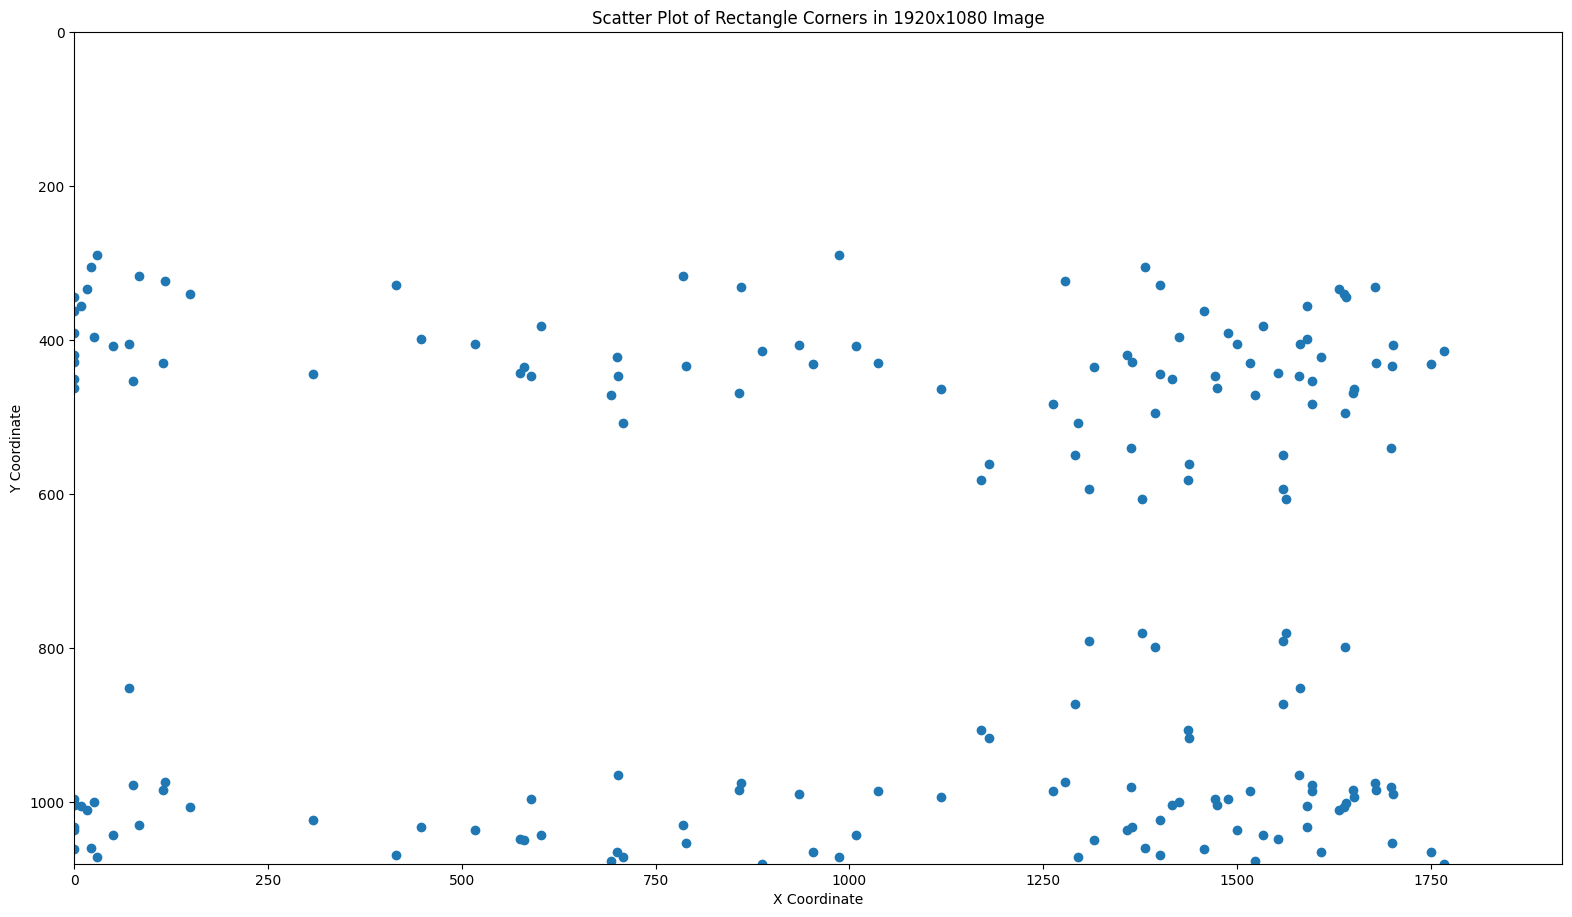

In [30]:
# Initialize lists to store x and y coordinates
x_coords = []
y_coords = []

# Iterate through the dictionary to extract all corners
for coords in bounding_box_data.values():
    # Check if coords is not None before unpacking
    if coords:
        x_min, y_min, x_max, y_max = coords

        # Add the corners to the lists
        x_coords.extend([x_min, x_max, x_min, x_max])
        y_coords.extend([y_min, y_min, y_max, y_max])

# Create a scatter plot
plt.figure(figsize=(19.20, 10.80))  # Size in inches to mimic 1920x1080
plt.scatter(x_coords, y_coords)
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Rectangle Corners in 1920x1080 Image')
plt.show()

In [31]:
# Initialize variables to hold extreme and sum values
max_x = max_y = float('-inf')
sum_x = sum_y = 0
count = 0

for coords in bounding_box_data.values():
    if coords:
        x_min, y_min, x_max, y_max = coords

        # Check for most bottom-right coordinate
        max_x = max(max_x, x_max)
        max_y = max(max_y, y_max)

        # Add to sum for average calculation
        sum_x += x_min + x_max
        sum_y += y_min + y_max
        count += 2  # Each box contributes 2 points (min and max)

# Calculate the average, if count is not zero
average_x = sum_x / count if count else None
average_y = sum_y / count if count else None
average_coord = (average_x, average_y) if count else None

# Display the results
print(f"Most Bottom-Right Coordinate: ({max_x}, {max_y})")
if average_coord:
    print(f"Average Coordinate: {average_coord}")
else:
    print("No valid data to calculate average coordinate.")

Most Bottom-Right Coordinate: (1766.735595703125, 1080.0)
Average Coordinate: (1019.5383162701384, 711.8059656670753)


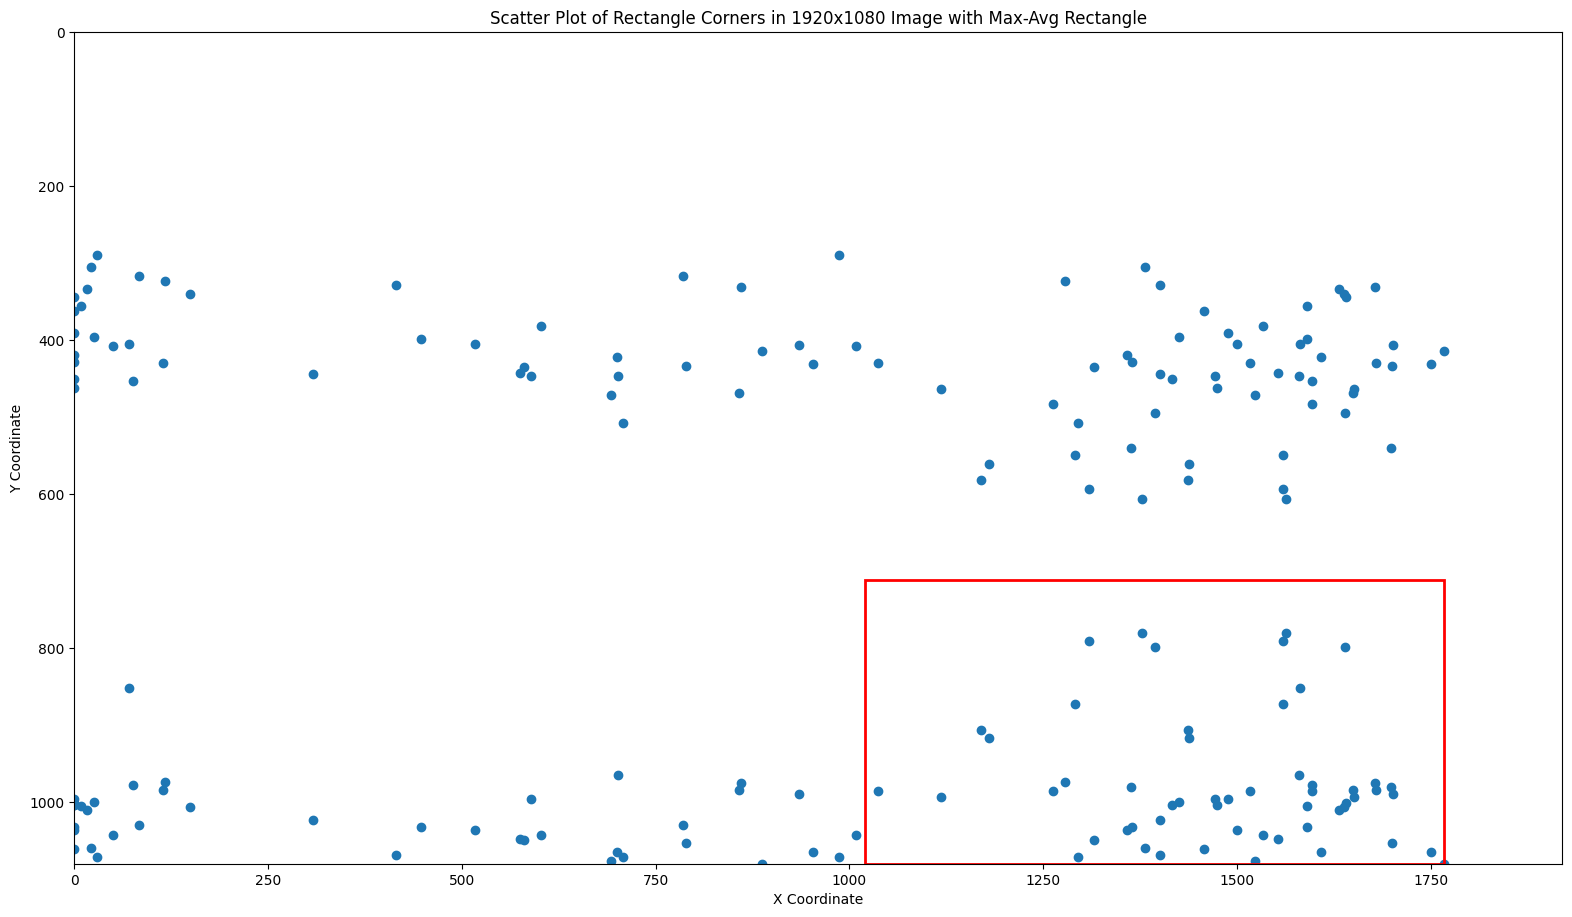

In [32]:
# Create a scatter plot
plt.figure(figsize=(19.20, 10.80))  # Size in inches to mimic 1920x1080
plt.scatter(x_coords, y_coords)
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates

# Add a red rectangle
if average_x is not None and average_y is not None:
    rect_width = max_x - average_x
    rect_height = max_y - average_y
    rect = patches.Rectangle((average_x, average_y), rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Rectangle Corners in 1920x1080 Image with Max-Avg Rectangle')
plt.show()

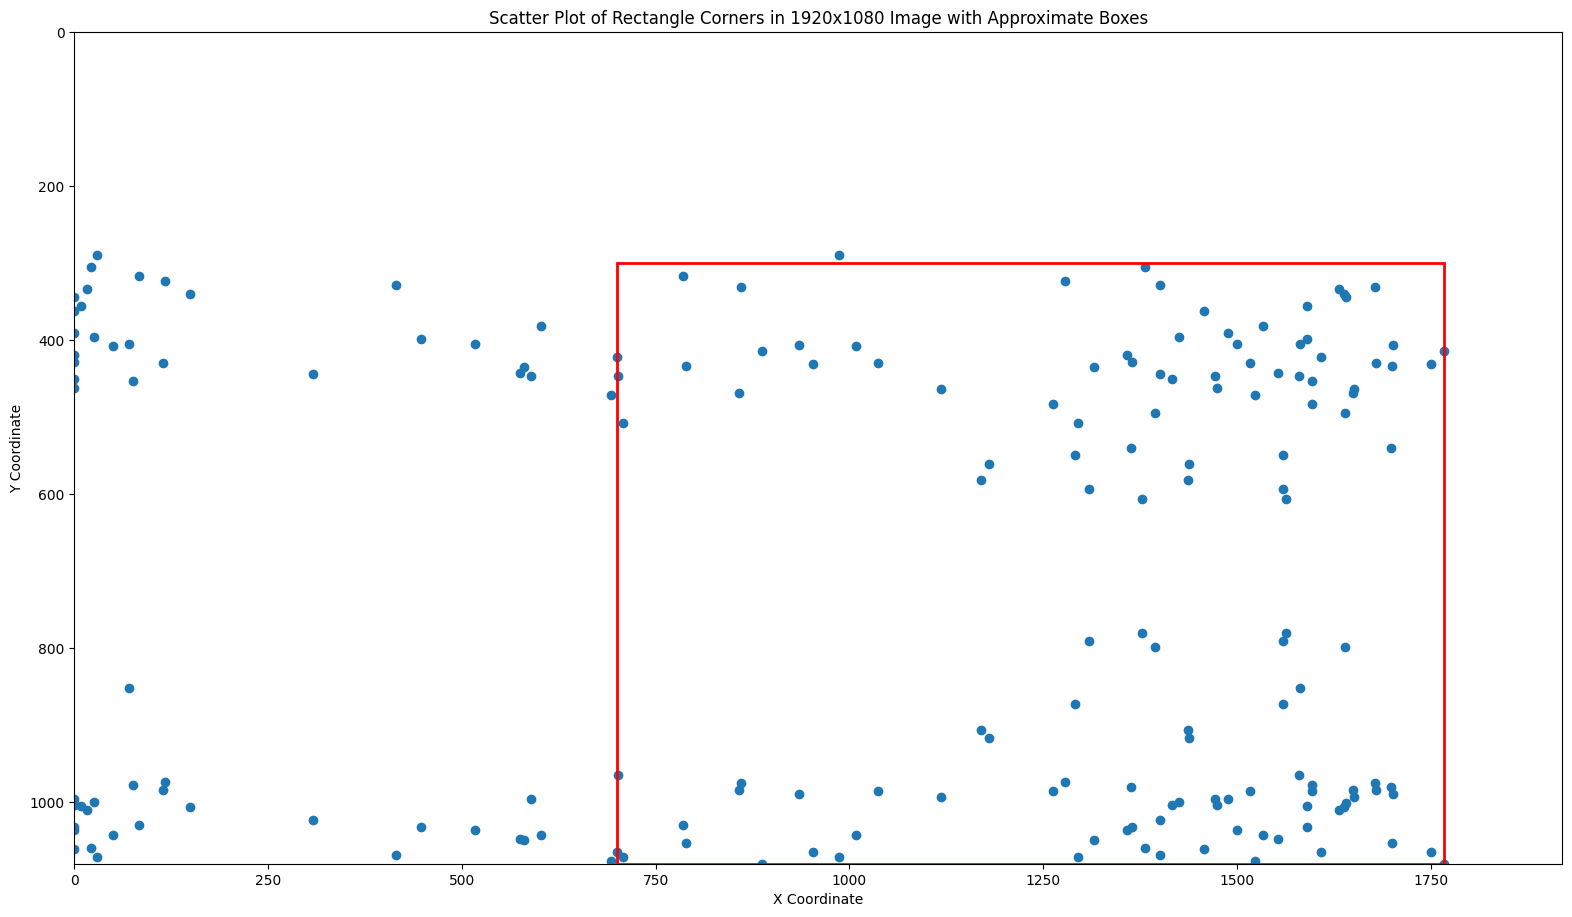

In [33]:
# Find the top-left corner for the smaller rectangle using a percentile (e.g., 50th percentile for median)
top_left_x = np.percentile(x_coords, 30)
top_left_y = 300

# Create a scatter plot
plt.figure(figsize=(19.20, 10.80))
plt.scatter(x_coords, y_coords)
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.gca().invert_yaxis()

# Draw the larger rectangle
plt.gca().add_patch(
    patches.Rectangle(
        (top_left_x, top_left_y),  # top-left corner
        max_x - top_left_x,        # width
        max_y - top_left_y,        # height
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
)

# Optionally, you can draw a smaller rectangle closer to a cluster of points
# by adjusting the percentile or using a fixed distance from the bottom-right corner

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Rectangle Corners in 1920x1080 Image with Approximate Boxes')
plt.show()


In [34]:
# [x_min, y_min, x_max, y_max]
crop_coordinates = [top_left_x, top_left_y, max_x, max_y]
crop_coordinates

[700.4810791015625, 300, 1766.735595703125, 1080.0]

In [35]:
cropped_paths_lower = crop_all_images_in_folders(all_rgb_upper_bound, crop_coordinates)

# Getting labels

In [36]:
def get_breathing_labels(visited_folders: list[str]) -> [list, list]:
    """
    Classifies folder names based on breathing patterns and returns their paths with corresponding labels.
    
    Args:
        visited_folders (List[str]): List of folder paths to be classified.

    Returns:
        Tuple[List[str], List[int]]: A tuple containing two lists - the first with folder paths, and the second with corresponding labels (0 for relaxed, 1 for hold breath).
    """

    all_frames_path = []
    all_labels = []

    hold_breath_pattern = r"/Hold Breath/|/Hold Breathe/|/H/"
    relaxed_pattern = r"/Relaxed/|/R/"

    for visited_folder in visited_folders:
        # Replace double backslashes with forward slashes
        standardized_folder = visited_folder.replace("\\", "/")

        if re.search(relaxed_pattern, standardized_folder, re.IGNORECASE):
            all_labels.append(RELAXED_LABEL)
        elif re.search(hold_breath_pattern, standardized_folder, re.IGNORECASE):
            all_labels.append(HOLD_BREATH_LABEL)
        else:
            print(f"Warning: No matching breathing pattern for {standardized_folder}")
            continue

        all_frames_path.append(standardized_folder)

    return all_frames_path, all_labels

In [37]:
# get labels for rgb

save_data = {}

label_path, breathing_labels = get_breathing_labels(cropped_paths_lower)

save_data["frames_path"] = label_path
save_data["labels_path"] = breathing_labels
save_data

{'frames_path': ['D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/With Blankets/Hold Breath/frames_Arun2_upper_bound-cropped',
  'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/With Blankets/Hold Breath/frames_Arun2_2_upper_bound-cropped',
  'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/With Blankets/Relaxed/frames_Arun2_upper_bound-cropped',
  'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/With Blankets/Relaxed/frames_Arun2_2_upper_bound-cropped',
  'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/Without Blankets/Hold Breath/frames_short_upper_bound-cropped',
  'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/2 Meters/Without Blankets/Relaxed/frames_relax 2meter short_upper_bound-cropped',
  'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/3 Meters/With Blankets/Hold Breath/frames_Arun3_upper_bound-cropped',
  'D:/DI_centre_structured/DI_CAMERA_P3225/Final/Arun/3 Meters/With Blankets/Relaxed/frames_Arun3_upper_bo

In [38]:
# save test train split in json data (rgb)
save_rgb_filename = json_dir + "/training_test_split/rgb_labels.json"
export_to_json(save_rgb_filename, save_data)